temp   focus
17.56  36.3
8.84   35.2

In [1]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter

from photutils.datasets import make_100gaussians_image
from photutils.background import Background2D, MedianBackground

from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel

from lvmagp.images import Image
from lvmagp.images.processors.detection import DaophotSourceDetection, SepSourceDetection
from lvmagp.focus.focusseries import ProjectionFocusSeries, PhotometryFocusSeries

from photutils.centroids import centroid_quadratic

from plotimg import plot_images

from cluplus.proxy  import invoke
from cluplus.proxy import Proxy


In [2]:
from plotimg import plot_images

async def focus_calc(focus, radius_data, images, source_detection):

    for idx, img in enumerate(images):
        images[idx].data = median_filter(images[idx].data, size=2)
        
        # photutils.background
        bkg_estimator = MedianBackground()
        bkg = Background2D(img.data.astype(float), (50, 50), filter_size=(3, 3),
                           bkg_estimator=bkg_estimator)
        images[idx].data = images[idx].data.astype(float) - bkg.background
        bkg_median = np.median(bkg.background)
        bkg_std = np.std(bkg.background)

        # sep.background
#        images[idx].bkg = sep.Background(images[idx].data.astype(float))
#        images[idx].data = images[idx].data.astype(float) - images[idx].bkg
#        bkg_median = np.median(images[idx].bkg)
#        bkg_std = np.std(bkg_median)
        
    for idx, img in enumerate(images):
        images[idx] = await source_detection(img)
#        images[idx].catalog.sort("fwhm")
        images[idx].catalog = images[idx].catalog[images[idx].catalog["peak"] > bkg_median + (1 * bkg_std) ]
        images[idx].catalog = images[idx].catalog[images[idx].catalog["peak"] < 65000]
        images[idx].catalog = images[idx].catalog[images[idx].catalog["ellipticity"] < 0.5]
        images[idx].catalog.sort("flux")
        images[idx].catalog.reverse()

        sources = images[idx].catalog
        if (len(sources) > 2):
            radius = np.median(sources[column][:num_stars])
            radius_err = np.std(sources[column][:num_stars])
            radius_data[idx].append({"focus": focus, "r": radius, "rerr": radius_err})

    return bkg_median, bkg_std


In [3]:
from lvmagp.focus.curvefit import fit_hyperbola

def focus_plot(images, data):
    #print(data)

    fig, ax = plt.subplots(1, ncols=(len(data)), figsize=(8, 5/len(data)))

    for idx, dd in enumerate(data):
        focus = [d["focus"] for d in dd]
        r = [d["r"] for d in dd]
        rerr = [d["rerr"] for d in dd]

        ax_idx = ax[idx] if len(data) > 1 else ax
        ax_idx.set_title(images[idx].header["CAMNAME"])
        ax_idx.errorbar(focus, r, yerr=rerr)

        fit_focus, fit_err = fit_hyperbola(focus, r, rerr)
        
    return fit_focus, fit_err


In [4]:
def temp2focus(t):
  return 0.12615 * t + 34.085


[WARNING]: actor lvm.sci.tel currently not reachable.
[WARNING]: coroutine 'Proxy.call_command' was never awaited (RuntimeWarning)


no temperature actor
 focus: 39.5 file: ['/data/lvm/sci/agcam/east/20221127/lvm.sci.agcam.east_00000004.fits', '/data/lvm/sci/agcam/center/20221127/lvm.sci.agcam.center_00000004.fits', '/data/lvm/sci/agcam/west/20221127/lvm.sci.agcam.west_00000004.fits']


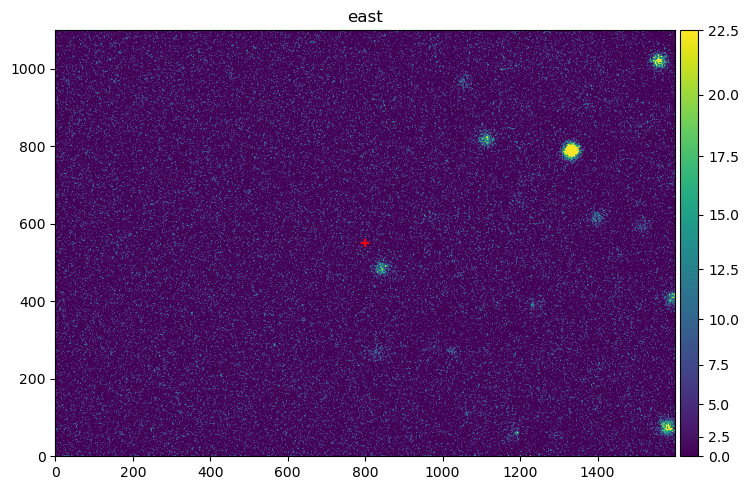

 focus: 40.166666666666664 file: ['/data/lvm/sci/agcam/east/20221127/lvm.sci.agcam.east_00000005.fits', '/data/lvm/sci/agcam/center/20221127/lvm.sci.agcam.center_00000005.fits', '/data/lvm/sci/agcam/west/20221127/lvm.sci.agcam.west_00000005.fits']


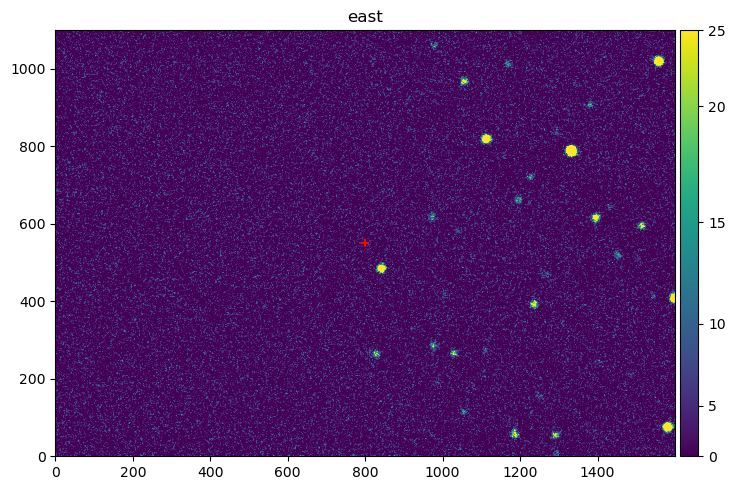

 focus: 40.833333333333336 file: ['/data/lvm/sci/agcam/east/20221127/lvm.sci.agcam.east_00000006.fits', '/data/lvm/sci/agcam/center/20221127/lvm.sci.agcam.center_00000006.fits', '/data/lvm/sci/agcam/west/20221127/lvm.sci.agcam.west_00000006.fits']


 focus: 41.5 file: ['/data/lvm/sci/agcam/east/20221127/lvm.sci.agcam.east_00000007.fits', '/data/lvm/sci/agcam/center/20221127/lvm.sci.agcam.center_00000007.fits', '/data/lvm/sci/agcam/west/20221127/lvm.sci.agcam.west_00000007.fits']


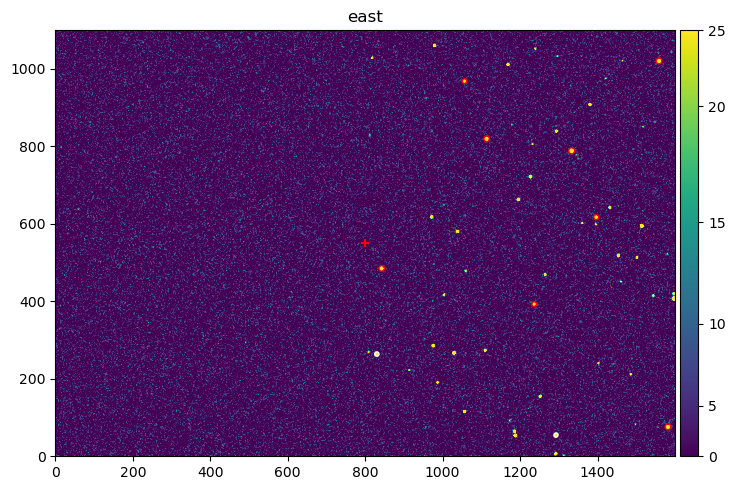

 focus: 42.166666666666664 file: ['/data/lvm/sci/agcam/east/20221127/lvm.sci.agcam.east_00000008.fits', '/data/lvm/sci/agcam/center/20221127/lvm.sci.agcam.center_00000008.fits', '/data/lvm/sci/agcam/west/20221127/lvm.sci.agcam.west_00000008.fits']


 focus: 42.833333333333336 file: ['/data/lvm/sci/agcam/east/20221127/lvm.sci.agcam.east_00000009.fits', '/data/lvm/sci/agcam/center/20221127/lvm.sci.agcam.center_00000009.fits', '/data/lvm/sci/agcam/west/20221127/lvm.sci.agcam.west_00000009.fits']


 focus: 43.5 file: ['/data/lvm/sci/agcam/east/20221127/lvm.sci.agcam.east_00000010.fits', '/data/lvm/sci/agcam/center/20221127/lvm.sci.agcam.center_00000010.fits', '/data/lvm/sci/agcam/west/20221127/lvm.sci.agcam.west_00000010.fits']


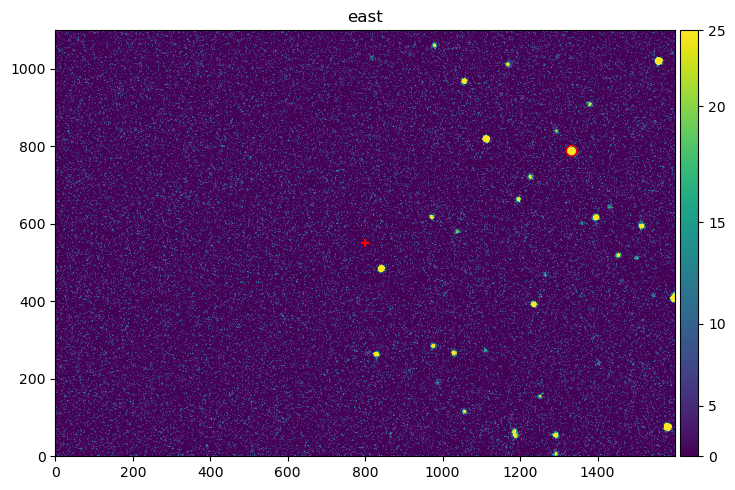

move focus: 42.043244902061815


{'Reachable': True,
 'AtHome': False,
 'Moving': False,
 'PositionSwitchStatus': 254,
 'Position': 42.043244902061815,
 'DeviceEncoder': {'Position': 1021.6224510309075, 'Unit': 'STEPS'},
 'Velocity': 0.0,
 'AtLimit': False}

In [7]:
%matplotlib inline
#%matplotlib widget

from lvmtipo.actors import lvm


threshold = 12.0
minarea = 24.0
deblend_nthresh = 1.4

source_detection = SepSourceDetection(threshold= threshold, minarea=minarea, deblend_nthresh=deblend_nthresh)

num_stars = 8
column = "fwhm"

await lvm.sci.pwi.start()
await lvm.sci.pwi.status()
await lvm.sci.foc.start()
await lvm.sci.foc.status()

await lvm.sci.agc.start()

lvm.sci.tel = await Proxy("lvm.sci.tel").start()

try:
    focus_guess=temp2focus(await(lvm.sci.tel.status()).flatten().unpack("temperature"))
except Exception as ex:
    print("no temperature actor")
    focus_guess=41.5

radius_data = None
expotime = 5.0

for focus in np.linspace(focus_guess-2, focus_guess+2, num=7):
    await lvm.sci.foc.moveAbsolute(focus, "DT")    
    filenames = (await lvm.sci.agc.expose(expotime)).flatten().unpack("*.filename")
    print(f" focus: {focus} file: {filenames}")
    images = [[Image.from_file(f) for f in filenames][0]]

    if not radius_data: radius_data = [list()]*len(images)
    await focus_calc(focus, radius_data, images, source_detection)
    plot_images(images, cat_max=num_stars, cat_rest=True)

fit_focus, fit_err = focus_plot(images, radius_data)

print (f"move focus: {fit_focus}")
await lvm.sci.foc.moveAbsolute(fit_focus, "DT")    



### Test

In [ ]:
%matplotlib inline
#%matplotlib widget


#fbase = lambda idx: f"/data/lvm/sci/agcam/east/20221028/lvm.sci.agcam.east_{idx:08}.fits"

#off=400
#num=15

#off=404
#num=5

#off=391
#num=7

#off=392
#num=5

#off=319 # to short 36 - 38, 0.5
#num=5

#off=329 #bad
#num=5

#off=392
#num=5

#off=365
#num=1

#off=400
#num=14

#off=430
#num=14

#off=415
#num=14

#off=419
#num=5

fbase = lambda idx: f"/data/lvm/sci/agcam/east/20221110/lvm.sci.agcam.east_{idx:08}.fits"

#off=77
#num=5

#off=87 #bad
#num=6

#off=121
#num=6

#off=128
#num=7

off=135
num=11



threshold = 3.2
minarea = 24.0
deblend_nthresh = 1.2
deblend_cont = 0.01

num_stars = 8

source_detection = SepSourceDetection(threshold=threshold, minarea=minarea, deblend_nthresh=deblend_nthresh, deblend_cont=deblend_cont)
#source_detection = SepSourceDetection()
#source_detection = DaophotSourceDetection(fwhm=4, threshold=30)

column = "fwhm"

radius_data = [[]]


for i in range(num):
    images = [Image.from_file(fbase(i+off))]
    focus = images[0].header["FOCUSUM"]
    temp = images[0].header["BENTEMP"]
#    print(images[0].header)
    print(f"temp: {temp} focus: {focus} exptime: {images[0].header['EXPTIME']} file: {fbase(i+off)}")

    bkg_median, bkg_std = await focus_calc(focus, radius_data, images, source_detection)
    print(f" bkg_median: {bkg_median} bkg_std: {bkg_std}")
    cat=images[0].catalog[:num_stars]
    print(f"{cat['x', 'y', 'peak', 'flux', 'fwhm', 'ellipticity'].pprint(max_width=120)}")

    plot_images(images, cat_max=num_stars, cat_rest=True, vmax=200)

focus_plot(images, radius_data)
